In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [93]:
def create_gauss_filter(h,w,k_size, sigma):
  k = cv2.getGaussianKernel(k_size,sigma)
  kernel = k@k.T
  filter = np.zeros((h,w))
  filter[(h-k_size)//2:(h+k_size)//2,(w-k_size)//2:(w+k_size)//2] = kernel
  filter = np.array(filter, np.float64)
  fft_filter = np.fft.fft2(filter)
  return filter, fft_filter

# funciones auxiliares
def fft2_mod(image):
  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


Se carga una imagen de prueba

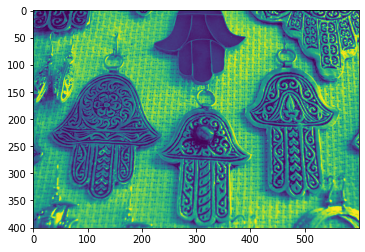

In [5]:
img = cv2.imread('/content/manito.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

Se aplica la fft2 a la imagen para visualizar su espectro de magnitud y se la antitransofrma para verificar

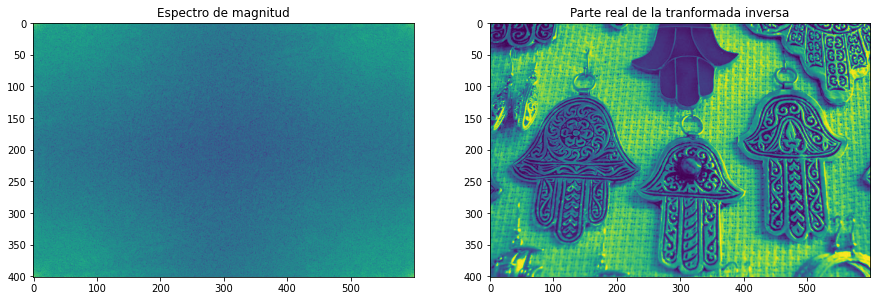

In [109]:
img_fft = np.fft.fft2(img)
plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(20*np.log10(np.abs(img_fft)))
plt.title('Espectro de magnitud')
plt.subplot(122)
plt.imshow(np.real(np.fft.ifft2(img_fft)))
plt.title('Parte real de la tranformada inversa');

Text(0.5, 1.0, 'Filtro en el dominio frecuencial')

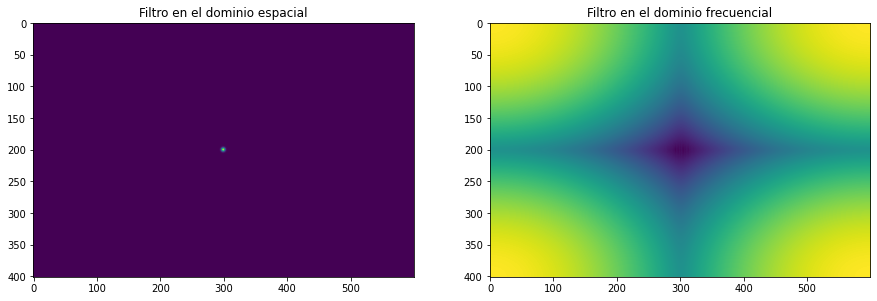

In [116]:
kernel_size = 25
sigma = 2

f, fftf = create_gauss_filter(img.shape[0],img.shape[1], kernel_size,sigma)
plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(f)
plt.title('Filtro en el dominio espacial')
plt.subplot(122)
plt.imshow(20*np.log10(np.abs(fftf)))
plt.title('Filtro en el dominio frecuencial')

Se aplica el filtro en el dominio de las frecuencias

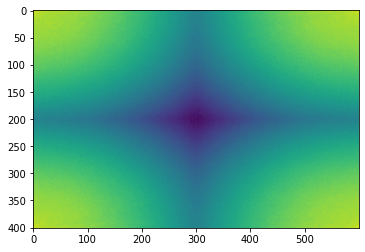

In [117]:
prod = img_fft * fftf
plt.figure()
plt.imshow(20*np.log10(np.abs(prod)))

Se aplica la transformada inversa para recuperar la imagen filtrada. Se comparan los resultados con el filtro implementado en OpenCV

In [118]:
filt_img = np.fft.ifft2(prod)
filt_img_cv2 = cv2.GaussianBlur(img,(kernel_size,kernel_size),sigma)


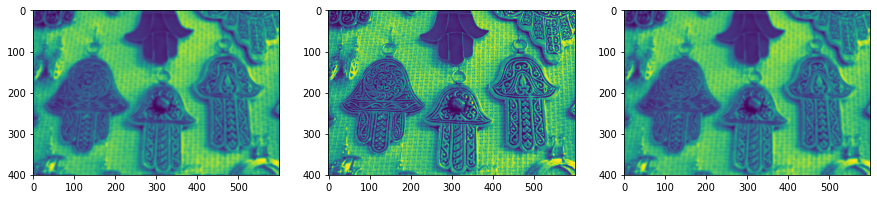

In [119]:
plt.figure(figsize = (15,15))
plt.subplot(131)
plt.imshow(np.fft.fftshift(np.real(filt_img)))
plt.subplot(132)
plt.imshow(img)
plt.subplot(133)
plt.imshow(filt_img_cv2)


Se aplica el mismo kernel pero con la operación convolucion

In [121]:
k = cv2.getGaussianKernel(kernel_size,sigma)
kernel = k@k.T

In [123]:
img_padding = cv2.copyMakeBorder(img, kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2, cv2.BORDER_CONSTANT, (0,0,0))

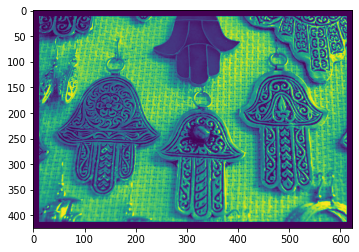

In [124]:
plt.imshow(img_padding)

In [127]:
result = np.zeros_like(img)
for i in range(img.shape[0]):
  for k in range(img.shape[1]):
    result[i,k] = np.sum(img_padding[i:i+kernel_size,k:k+kernel_size] * kernel)

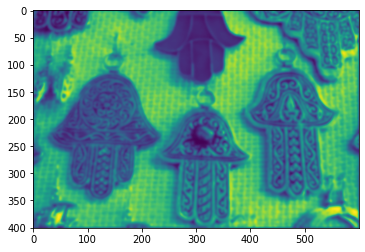

In [128]:
plt.imshow(result)

Parte 2

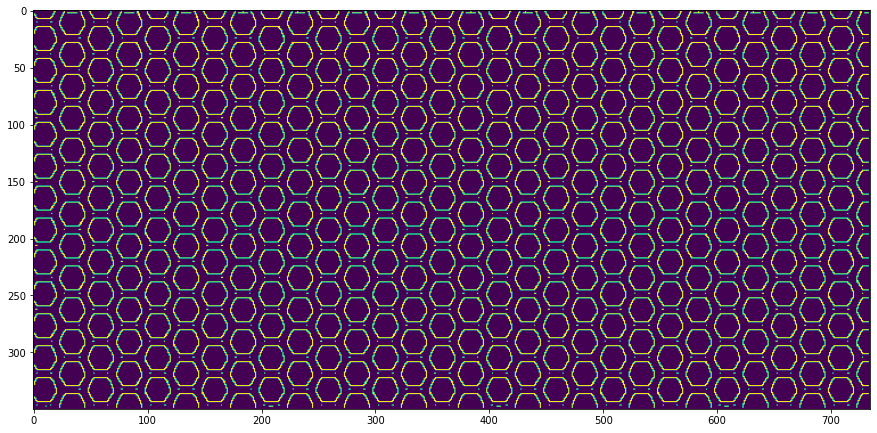

In [158]:
img = cv2.imread('metalgrid.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Suavizado Gaussiano
#====================

blur = cv2.GaussianBlur(gray,(5,5),0)

# Gradientes
#===========


# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv2.Sobel(blur,cv2.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# De igual modo para Sobely
sobely_64 = cv2.Sobel(blur,cv2.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

# Supresión de no-máximos
#========================

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


# Umbralizado por histéresis
#===========================

UmbralAlto = 25
UmbralBajo = 17

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 0


# Armo la imagen de bordes
#=========================
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0


# Muestro la imagen
#==================
plt.figure(figsize=(15,15))
plt.imshow(out)

In [159]:
for i,j in zip(strong_i,strong_j):
    # Horizontal 0
    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
        img[i,j] = (255,0,0)
    # Diagonal 45
    elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
        img[i,j] = (255,255,0)
    # Vertical 90
    elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
        img[i,j] = (255,0,255)
    # Diagonal 135
    elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
        img[i,j] = (0,0,255)          
        




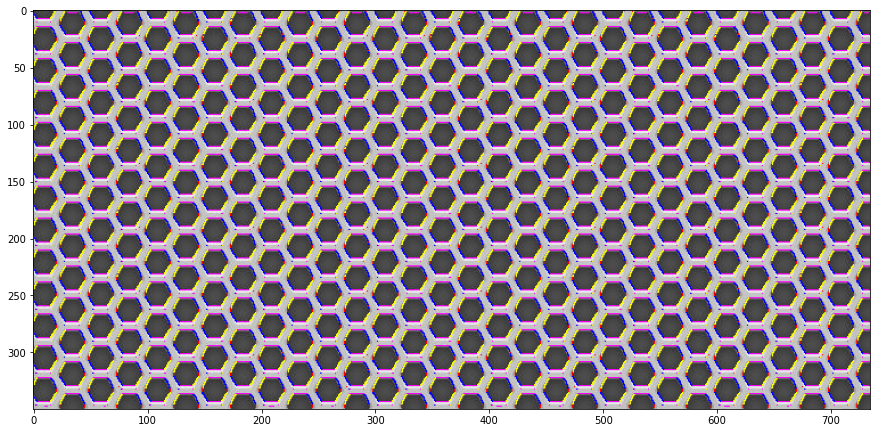

In [160]:
  plt.figure(figsize=(15,15))
  plt.imshow(img)